In [1]:
from sklearn.datasets import make_regression, make_moons
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, explained_variance_score

from scipy.stats import pearsonr, spearmanr

In [2]:
def interval_transform(x, a, b):
    m = x.min()
    ma = x.max()
    
    alpha_inv = (1 - m/ma)*ma/(a - b)
    alpha = 1/alpha_inv
    beta = b - alpha*m
    
    f = lambda x: alpha*x + beta 
    return f(x)

def make_noise_feature(x):
    n_features = x.shape[1]
    n_samples = x.shape[0]
    
    weights = np.random.uniform(1e-4, 1e-2, n_features)
    noise = np.random.normal(1, 5, n_samples)
    signal = np.sum(weights*x, -1) 
    return signal + noise

def calculate_pvalues(df,
                      method = spearmanr
                     ):
    """
    Assumes df with only numeric entries clean of null entries. 
    """
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(method(df[r], df[c])[1], 4)
    return pvalues

def correlation_matrix(df,
                       method = "pearson",
                       annot_bool = False,
                       annot_size = 20
                      ):
    # Compute the correlation matrix
    corr = df.corr(method = method)

    if annot_bool:
        annot = corr.copy()
        
        if method == "pearson":
            sig_meth = pearsonr
        else:
            sig_meth = spearmanr
            
        pval = calculate_pvalues(df, sig_meth) 
        # create three masks
        r0 = corr.applymap(lambda x: '{:.2f}'.format(x))
        r1 = corr.applymap(lambda x: '{:.2f}*'.format(x))
        r2 = corr.applymap(lambda x: '{:.2f}**'.format(x))
        r3 = corr.applymap(lambda x: '{:.2f}***'.format(x))
  
        # apply them where appropriate --this could be a single liner
        annot = annot.where(pval>0.1,r0)
        annot = annot.where(pval<=0.1,r1)
        annot = annot.where(pval<=0.05,r2)
        annot = annot.mask(pval<=0.01,r3)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 11))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                annot = annot,
                fmt = "",
                annot_kws={"size": annot_size},
                vmin = -1,
                vmax = 1,
               )

In [3]:
n_info = 3
n_redu = 0
n_samples=2000

#making nonlinear decision boundaries requires multiple blob like features 
X1, y1 = make_regression(
        n_samples=n_samples,
        n_features=3,
        n_informative=n_info,
        #n_redundant=n_redu,
        shuffle=False,
        random_state=42,
        #difficulty
        effective_rank=2,
        noise=0.6,
        tail_strength=0.2,
        bias=12,
        )

X2, y2 = make_regression(
        n_samples=n_samples,
        n_features=3,
        n_informative=n_info,
        #n_redundant=n_redu,
        shuffle=False,
        random_state=6, 
        #difficulty
        effective_rank=1,
        noise=1.1,
        tail_strength=0.3,
        bias=10,
        )

#X3, y3 = make_moons(n_samples=2*n_samples, noise=1, random_state=42)

X = np.concatenate([X1, X2], axis=0)
y = np.concatenate([y1, y2], axis=0)

data = np.concatenate([X, np.expand_dims(y, -1)], -1)
data = pd.DataFrame(data)

In [4]:
print(X.shape)

(4000, 3)


In [5]:
data.head()

,0,1,2,3
0,0.006830,0.011368,0.001180,12.760640
1,0.031064,0.013168,0.005510,15.361742
2,0.029670,0.008490,0.023335,17.398501
3,0.014298,0.002184,-0.004970,13.139080
4,0.019918,-0.008383,-0.033225,11.880456


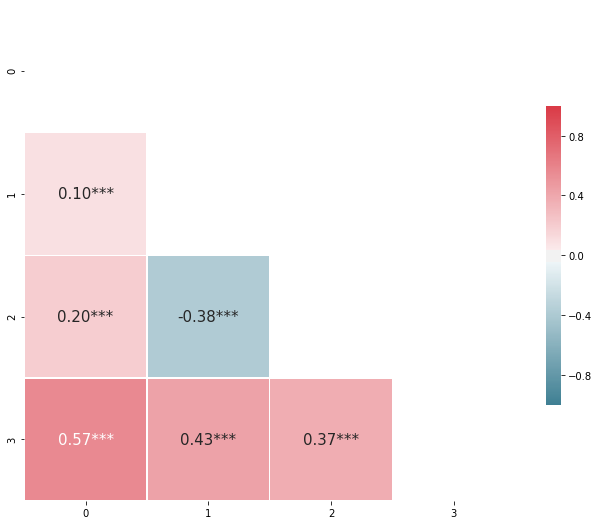

In [6]:
correlation_matrix(data, annot_bool=True, annot_size=15)

(array([  17.,   75.,  493., 1336., 1181.,  490.,  268.,  101.,   36.,
           3.]),
 array([ 2.67394882,  4.64128185,  6.60861487,  8.57594789, 10.54328092,
        12.51061394, 14.47794696, 16.44527999, 18.41261301, 20.37994603,
        22.34727906]),
 <a list of 10 Patch objects>)

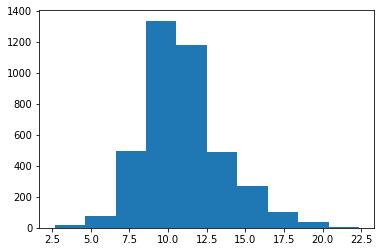

In [7]:
plt.hist(y)

To educationify the data we scale and transform the dataset:

For the informative features we'll use:
* GPA [0, 4] unit:grade
* Attendance [0, 100] unit:percent
* Passed percent of classes [0, 100] unit:percent

For the redundant we'll use: 
* Sex [0, 1] unit:integer class
* Ethnicity [0, 1, 2] unit:integer class
* HSGPA [0, 4] unit:grade


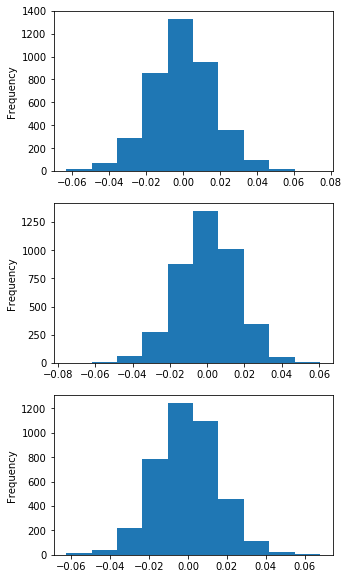

In [8]:
fig, axs = plt.subplots(nrows=n_info, figsize=(5, 10 ))
for i in range(n_info):
    ax = axs[i]
    data[i].plot(kind="hist", ax=ax)

(array([   5.,   25.,  115.,  456., 1095., 1248.,  788.,  221.,   36.,
          11.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

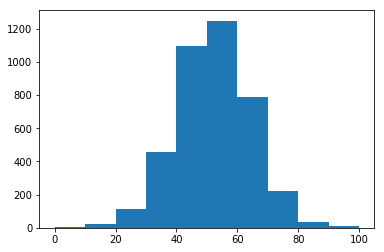

In [9]:
attendance_column = interval_transform(data[2], 0, 100)
plt.hist(attendance_column)

(array([  11.,   57.,  343., 1012., 1350.,  881.,  272.,   65.,    7.,
           2.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

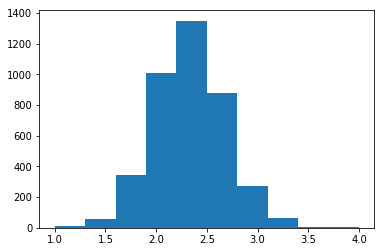

In [10]:
gpa_column = interval_transform(data[1], 1, 4) 
plt.hist(gpa_column)

(array([   2.,   22.,   93.,  362.,  952., 1330.,  860.,  287.,   72.,
          20.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

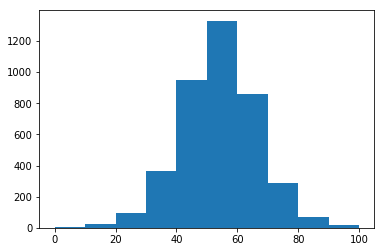

In [11]:
passed_column = interval_transform(data[0], 0, 100)
plt.hist(passed_column)

(array([2023.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1977.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

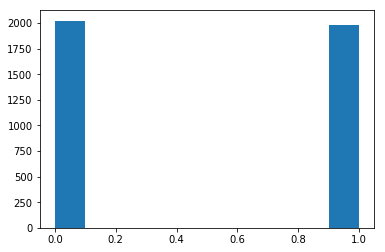

In [12]:
sex_column = make_noise_feature(X)
sex_column = (sex_column > sex_column.mean()).astype(int)
plt.hist(sex_column)

(array([   7.,   41.,  186.,  479.,  936., 1024.,  820.,  374.,  107.,
          26.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

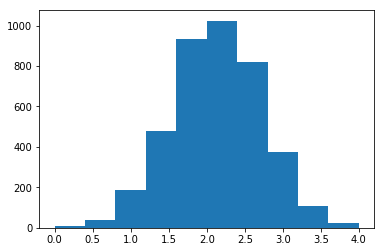

In [13]:
hsgpa_column = interval_transform(make_noise_feature(X), 0, 4)
plt.hist(hsgpa_column)

(array([1000.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
        2000.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

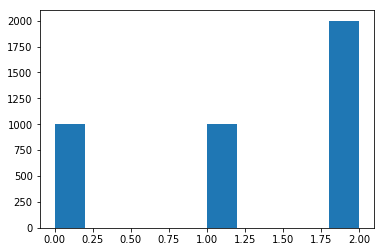

In [14]:
ethn_column = make_noise_feature(X)
ethn_column = pd.qcut(ethn_column, q=[0, .25, .5, 1], labels=[0, 1, 2])
plt.hist(ethn_column)

(array([   3.,   36.,  101.,  268.,  490., 1181., 1336.,  493.,   75.,
          17.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

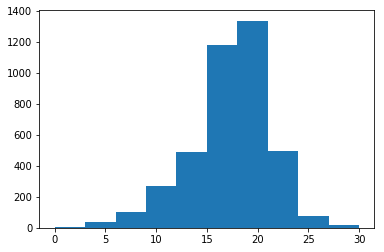

In [27]:
fci_post = interval_transform(y, 0, 30)
plt.hist(fci_post)

In [15]:
gpa_column.shape

(4000,)

In [28]:
full_data = np.concatenate(
                [
                    np.expand_dims(gpa_column, axis=-1),
                    np.expand_dims(attendance_column, axis=-1),
                    np.expand_dims(passed_column, axis=-1),
                    np.expand_dims(sex_column, axis=-1),
                    np.expand_dims(hsgpa_column, axis=-1),
                    np.expand_dims(ethn_column, axis=-1),
                    np.expand_dims(fci_post, axis=-1)
                ],
                axis=1
)

columns = [              
           "cGPA",
           "attendance",
           "passed_percent",
           "sex",
           "hsGPA",
           "ethnicity",
           "fci_post"]

df_full = pd.DataFrame(full_data,
                       columns=columns)

In [29]:
df_full.head()

,cGPA,attendance,passed_percent,sex,hsGPA,ethnicity,fci_post
0,2.083621,51.137226,48.929495,0.0,1.938091,2.0,14.618734
1,2.043927,47.819398,31.298644,0.0,1.319788,0.0,10.652295
2,2.147087,34.160519,32.312813,0.0,0.868846,2.0,7.546426
3,2.286152,55.850494,43.496181,1.0,1.794798,0.0,14.041647
4,2.519186,77.501019,39.407797,0.0,2.540807,1.0,15.960932


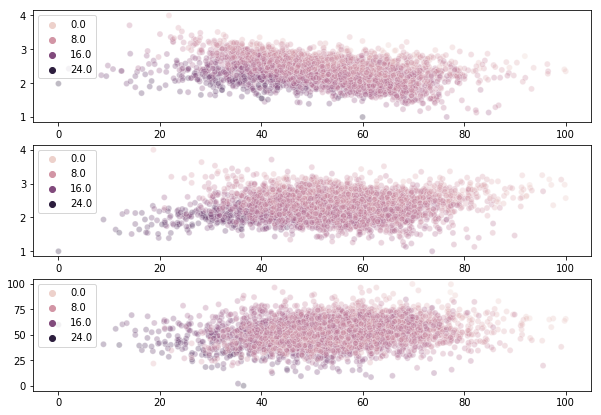

In [30]:
comb = [(1, 0), (2, 0), (2, 1)]
fig, axs = plt.subplots(nrows=len(comb), figsize=(10, 7))

for i in range(len(comb)):
    sns.scatterplot(full_data[:,comb[i][0]], full_data[:,comb[i][1]], hue=y, ax=axs[i], alpha=0.3)

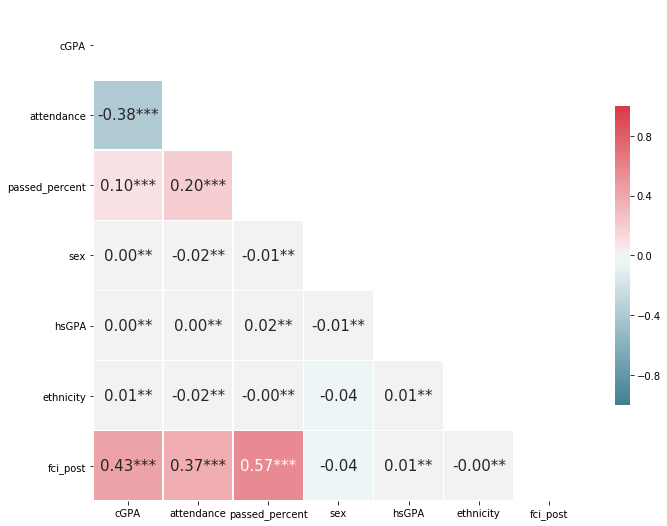

In [31]:
correlation_matrix(df_full, annot_bool=True, annot_size=15)

In [32]:
t_X = X.copy()
fd = full_data[:, :-1].copy()

for i in range(t_X.shape[1]):
    t_X[:,i] = (t_X[:,i] - t_X[:,i].mean())/t_X[:,i].std()
    
for i in [0, 1, 2, -1]:
    fd[:,i] = (fd[:,i] - fd[:,i].mean())/fd[:,i].std()

    
data_c = [c for c in columns if c != "fci_post"]
clf_data = df_full[data_c].values
clf_targets = df_full["fci_post"].values

#x_train, x_test, y_train, y_test = train_test_split(t_X, y, shuffle=True)
x_train, x_test, y_train, y_test = train_test_split(fd, full_data[:,-1], shuffle=True)

In [33]:
model = LinearRegression()
model.fit(x_train, y_train)

mlp_model = MLPRegressor(
                activation="relu",
                hidden_layer_sizes=[100, ]*20,
                max_iter=1000,
                early_stopping=True,
                validation_fraction=0.2,
                alpha=0.1,
                beta_1=0.8,
                learning_rate_init=0.0001
                )

mlp_model.fit(x_train, y_train)

rf_model = RandomForestRegressor(max_features=3)
rf_model.fit(x_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [34]:
print("LR model", r2_score(y_test, model.predict(x_test)))
print("MLP model", r2_score(y_test, mlp_model.predict(x_test)))
print("RF model", r2_score(y_test, rf_model.predict(x_test)))

LR model 0.696246561144778
MLP model 0.7616682353843084
RF model 0.7114658033478302


In [24]:
pd.to_pickle(df_full, "regression_data.pkl")